In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from PIL import Image
import os

In [2]:
DATASET_DIR = "New_Dataset"
BATCH_SIZE = 32
EPOCHS = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)


Using device: cuda


In [ ]:
#  Data Augmentation & Normalization
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [ ]:
# Load Dataset
train_data = datasets.ImageFolder(f"{DATASET_DIR}/train", transform=train_transforms)
val_data = datasets.ImageFolder(f"{DATASET_DIR}/val", transform=val_transforms)
test_data = datasets.ImageFolder(f"{DATASET_DIR}/test", transform=val_transforms)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

class_names = train_data.classes
print("Classes:", class_names)


Classes: ['Healthy_Soyabean', 'Soyabean_Mosaic', 'Soyabean_Rust', 'Soyabean_Spectoria_Brown_Spot']


In [ ]:
# Load Pretrained Model (EfficientNet-B0)
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

# Freeze feature extractor
for param in model.features.parameters():
    param.requires_grad = False

# Replace classifier
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_features, len(class_names))
)

model = model.to(DEVICE)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\hazoa/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth


100.0%


In [ ]:
# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# Training Loop (Save Model Every Epoch)
best_acc = 0.0

for epoch in range(EPOCHS):
    # --- Training ---
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)

    # --- Validation ---
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    acc = correct / total

    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {epoch_loss:.4f} | Val Acc: {acc:.4f}")

    # Save model every epoch
    os.makedirs("checkpoints", exist_ok=True)
    torch.save(model.state_dict(), f"checkpoints/soyabean_epoch{epoch+1}.pth")

    # Save best model separately
    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), "best_soyabean_model.pth")

print("✅ Training complete! Best Val Acc:", best_acc)


Epoch 1/10 | Loss: 0.9387 | Val Acc: 0.7515
Epoch 2/10 | Loss: 0.6795 | Val Acc: 0.7574
Epoch 3/10 | Loss: 0.6225 | Val Acc: 0.7632
Epoch 4/10 | Loss: 0.6111 | Val Acc: 0.7647
Epoch 5/10 | Loss: 0.6026 | Val Acc: 0.7765
Epoch 6/10 | Loss: 0.5879 | Val Acc: 0.7676
Epoch 7/10 | Loss: 0.5924 | Val Acc: 0.7559
Epoch 8/10 | Loss: 0.5739 | Val Acc: 0.7941
Epoch 9/10 | Loss: 0.5642 | Val Acc: 0.7647
Epoch 10/10 | Loss: 0.5809 | Val Acc: 0.7618
✅ Training complete! Best Val Acc: 0.7941176470588235


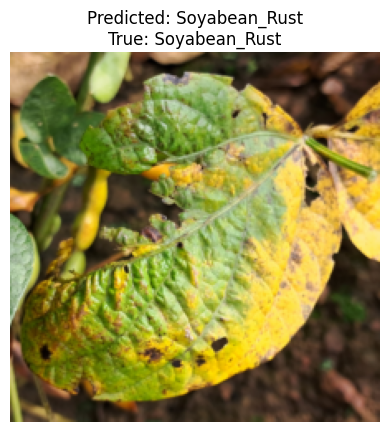

In [12]:
import numpy as np
import matplotlib.pyplot as plt
# Load the best model weights
model.load_state_dict(torch.load("best_soyabean_model.pth", map_location=DEVICE))
model.eval()

# Take a random image from the test set
img_path, true_label = test_data.samples[200]  # You can change the index for a different image
img_pil = Image.open(img_path).convert("RGB")
img_tensor = val_transforms(img_pil).unsqueeze(0).to(DEVICE)

# Predict
with torch.no_grad():
    output = model(img_tensor)
    pred_label = output.argmax(1).item()

# Unnormalize for visualization
img_np = img_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img_np = std * img_np + mean
img_np = np.clip(img_np, 0, 1)

plt.imshow(img_np)
plt.title(f"Predicted: {class_names[pred_label]}\nTrue: {class_names[true_label]}")
plt.axis('off')
plt.show()